In [1]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'

In [4]:
# Initialize a dictionary to store file paths for each category
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Iterate over the dataset folders (Bonafide, Spoofed_TTS, Spoofed_Tacotron)
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        # Handle Bonafide folder with Part 1 and Part 2 subfolders
        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    file_path = os.path.join(part_path, file)
                    if file.endswith('.wav'):  # Check if it's a valid audio file
                        audio_files[category].append(file_path)

        # Handle Spoofed_TTS and Spoofed_Tacotron (assuming these don't have parts)
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                file_path = os.path.join(speaker_path, file)
                if file.endswith('.wav'):  # Check if it's a valid audio file
                    audio_files[category].append(file_path)

# Check the loaded audio files
print("Bonafide files:", audio_files['Bonafide'])
print("Spoofed_TTS files:", audio_files['Spoofed_TTS'])
print("Spoofed_Tacotron files:", audio_files['Spoofed_Tacotron'])

Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 421538.09it/s]

Bonafide files: ['/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/10.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/105.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/103.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/101.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/100.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/102.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/316.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/114.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/16.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/458.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/128.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/28.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/313.wav', '/content/drive/MyDrive/DATASET/Bonafide/Speaker_11/Part 1/15.wav', '/content/drive/MyDri

In [5]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)

Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [6]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# === Chromagram extraction function ===
def extract_chromagram(file_path, n_chroma=12, max_length=400, sr=22050, hop_length=512):
    y, _ = librosa.load(file_path, sr=sr)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_chroma=n_chroma)

    # Pad or trim chromagram to fixed width
    if chroma.shape[1] < max_length:
        chroma = np.pad(chroma, ((0, 0), (0, max_length - chroma.shape[1])), mode='constant')
    else:
        chroma = chroma[:, :max_length]

    return chroma

# === Feature and label extraction ===
def extract_chromagram_features_and_labels(dataset_path, n_chroma=12, max_length=400):
    features = []
    labels = []

    for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
        category_path = os.path.join(dataset_path, category)

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)

            # Handle Bonafide/Part 1 and Part 2
            if category == 'Bonafide':
                for part in ['Part 1', 'Part 2']:
                    part_path = os.path.join(speaker_path, part)
                    if not os.path.isdir(part_path):
                        continue
                    for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                        file_path = os.path.join(part_path, file)
                        if file.endswith('.wav'):
                            try:
                                chroma = extract_chromagram(file_path, n_chroma, max_length)
                                features.append(chroma)
                                labels.append(0)  # Bonafide
                            except Exception as e:
                                print(f"Error processing {file_path}: {e}")
            else:
                # Handle spoofed categories
                for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                    file_path = os.path.join(speaker_path, file)
                    if file.endswith('.wav'):
                        try:
                            chroma = extract_chromagram(file_path, n_chroma, max_length)
                            features.append(chroma)
                            labels.append(1)  # Spoofed
                        except Exception as e:
                            print(f"Error processing {file_path}: {e}")

    return np.array(features), np.array(labels)


# Extract chromagram features and labels
features, labels = extract_chromagram_features_and_labels(dataset_path)

# Save to .npy files
np.save("/content/drive/MyDrive/chromagram_features.npy", features)
np.save("/content/drive/MyDrive/chromagram_labels.npy", labels)

print(f"\n✅ Saved chromagram features: {features.shape}")
print(f"✅ Saved labels: {labels.shape}")


Processing Spoofed_Tacotron/Speaker_05:  99%|█████████▉| 98/99 [00:46<00:00,  2.17it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:10<00:00,  9.17it/s]



✅ Saved chromagram features: (6814, 12, 400)
✅ Saved labels: (6814,)


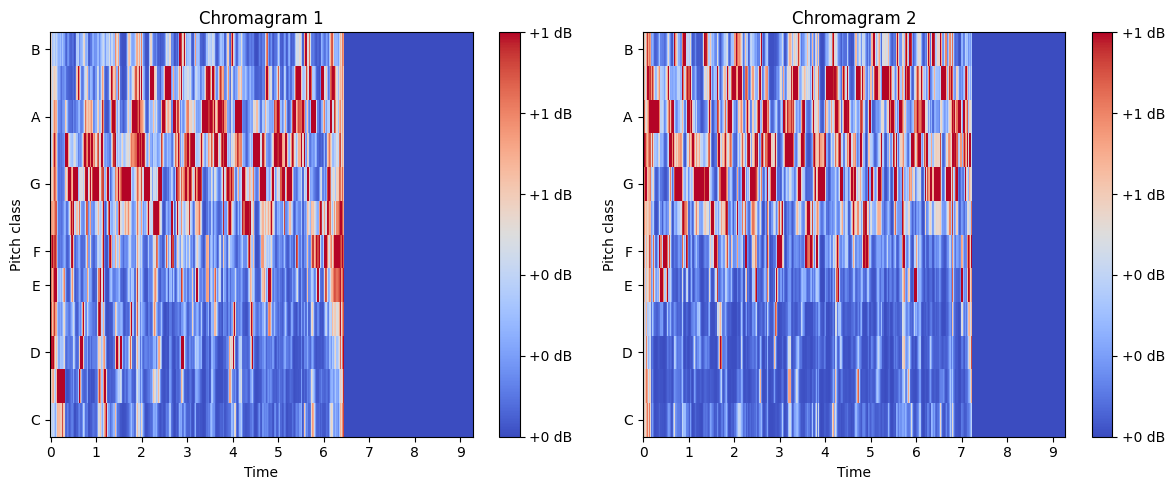

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

# Load saved chromagram features
chromagram_path = "/content/drive/MyDrive/chromagram_features.npy"
chromagrams = np.load(chromagram_path)  # Shape: (6814, 12, 400)

# Visualize the first two chromagrams
plt.figure(figsize=(12, 5))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    librosa.display.specshow(chromagrams[i], x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.title(f'Chromagram {i+1}')
    plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import h5py

# Step 1: Load chromagram features and labels
chromagram_path = '/content/drive/MyDrive/chromagram_features.npy'
labels_path = '/content/drive/MyDrive/labels.npy'

x = np.load(chromagram_path)  # Shape: (6814, 12, 400)
y = np.load(labels_path)      # Shape: (6814,)

# Step 2: Flatten chromagrams (12 x 400 → 4800)
x = x.reshape(x.shape[0], -1)  # Now shape: (6814, 4800)

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 5: Create DataLoaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Step 6: Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=4800, hidden_dim=512, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 7: Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=4800).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Step 9: Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

# Step 10: Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("\n=== Evaluation Metrics ===")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"EER        : {eer:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 11: Save model weights
save_path = '/content/drive/MyDrive/mlp_chromagram_weights.h5'
torch.save(model.state_dict(), "/content/drive/MyDrive/mlp_chromagram_model.pth")

with h5py.File(save_path, 'w') as hf:
    for name, param in model.state_dict().items():
        hf.create_dataset(name, data=param.cpu().numpy())

print(f"\n✅ Chromagram MLP model weights saved to: {save_path}")


Epoch 1/12, Loss: 0.6349
Epoch 2/12, Loss: 0.5037
Epoch 3/12, Loss: 0.4145
Epoch 4/12, Loss: 0.3500
Epoch 5/12, Loss: 0.2769
Epoch 6/12, Loss: 0.1946
Epoch 7/12, Loss: 0.1600
Epoch 8/12, Loss: 0.1393
Epoch 9/12, Loss: 0.0966
Epoch 10/12, Loss: 0.0585
Epoch 11/12, Loss: 0.0685
Epoch 12/12, Loss: 0.0320

=== Evaluation Metrics ===
Accuracy   : 0.7469
Precision  : 0.7738
F1 Score   : 0.7324
EER        : 0.2544
Confusion Matrix:
[[546 138]
 [207 472]]

✅ Chromagram MLP model weights saved to: /content/drive/MyDrive/mlp_chromagram_weights.h5


In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import h5py

# Step 1: Load chromagram features and labels
chromagram_path = '/content/drive/MyDrive/chromagram_features.npy'
labels_path = '/content/drive/MyDrive/labels.npy'

x = np.load(chromagram_path)  # Shape: (6814, 12, 400)
y = np.load(labels_path)      # Shape: (6814,)

# Step 2: Flatten chromagrams (12 x 400 → 4800)
x = x.reshape(x.shape[0], -1)  # Now shape: (6814, 4800)

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 5: Create DataLoaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Step 6: Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=4800, hidden_dim=512, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout1(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

# Step 7: Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=4800).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Step 9: Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

# Step 10: Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("\n=== Evaluation Metrics ===")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"EER        : {eer:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 11: Save model weights
save_path = '/content/drive/MyDrive/mlp_chromagram_weights.h5'
torch.save(model.state_dict(), "/content/drive/MyDrive/mlp_chromagram_model.pth")

with h5py.File(save_path, 'w') as hf:
    for name, param in model.state_dict().items():
        hf.create_dataset(name, data=param.cpu().numpy())

print(f"\n✅ Chromagram MLP model weights saved to: {save_path}")


Epoch 1/12, Loss: 0.5858
Epoch 2/12, Loss: 0.4163
Epoch 3/12, Loss: 0.3280
Epoch 4/12, Loss: 0.2374
Epoch 5/12, Loss: 0.1829
Epoch 6/12, Loss: 0.1436
Epoch 7/12, Loss: 0.1309
Epoch 8/12, Loss: 0.1153
Epoch 9/12, Loss: 0.0794
Epoch 10/12, Loss: 0.1043
Epoch 11/12, Loss: 0.0752
Epoch 12/12, Loss: 0.0672

=== Evaluation Metrics ===
Accuracy   : 0.7601
Precision  : 0.8296
F1 Score   : 0.7304
EER        : 0.2339
Confusion Matrix:
[[593  91]
 [236 443]]

✅ Chromagram MLP model weights saved to: /content/drive/MyDrive/mlp_chromagram_weights.h5


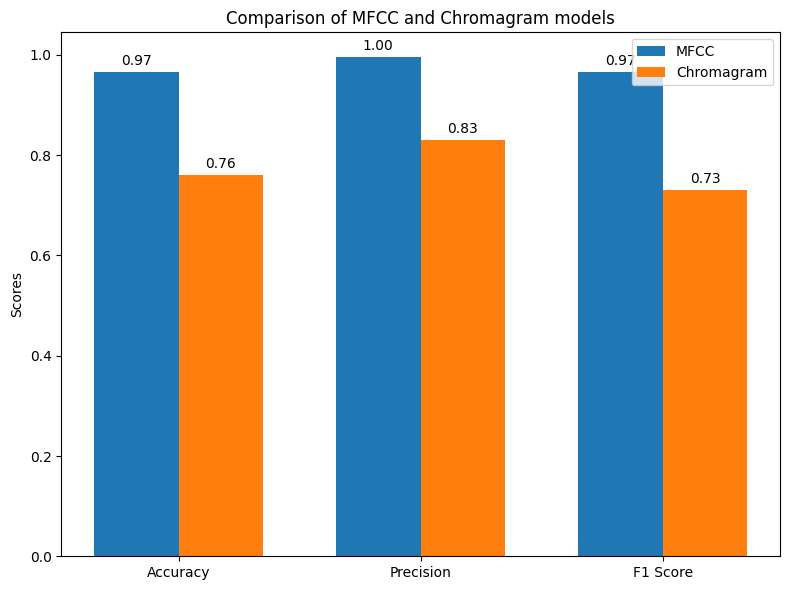

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import os

# Step 1: Define the MLP model *without* BatchNorm and Dropout
# This definition matches the likely structure of the saved mlp_model.pth
class MLP_Simple(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLP_Simple, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 2: Load the MFCC test data
mfcc_path = '/content/drive/MyDrive/mfcc_features.npy'
labels_path = '/content/drive/MyDrive/labels.npy'

# Make sure mfcc_features.npy exists before loading
if not os.path.exists(mfcc_path):
     print(f"Error: MFCC features file not found at {mfcc_path}")
     # You might want to extract MFCC features here or provide instructions
     # for the user to run the relevant cell(s) that generate this file.
     # Exit or handle the error appropriately if the file is missing
     exit() # Added exit for demonstration, adjust based on desired behavior
else:
    x_mfcc = np.load(mfcc_path)
    y_mfcc = np.load(labels_path)
    x_mfcc = x_mfcc.reshape(x_mfcc.shape[0], -1)  # Flatten MFCCs

    # Split the MFCC data (we'll use 80% for training and 20% for testing)
    # This split needs to be consistent with how the model was trained
    x_train_mfcc, x_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(x_mfcc, y_mfcc, test_size=0.2, random_state=42, stratify=y_mfcc)

# Convert MFCC to PyTorch tensors
x_test_tensor_mfcc = torch.tensor(x_test_mfcc, dtype=torch.float32)
y_test_tensor_mfcc = torch.tensor(y_test_mfcc, dtype=torch.long)

# Step 3: Load the Chromagram test data
chromagram_path = '/content/drive/MyDrive/chromagram_features.npy'

# Make sure chromagram_features.npy exists before loading
if not os.path.exists(chromagram_path):
     print(f"Error: Chromagram features file not found at {chromagram_path}")
     # You might want to extract Chromagram features here or provide instructions
     # for the user to run the relevant cell(s) that generate this file.
     # Exit or handle the error appropriately if the file is missing
     exit() # Added exit for demonstration, adjust based on desired behavior
else:
    x_chromagram = np.load(chromagram_path)
    # Assuming labels_path is the same for both MFCC and Chromagram
    y_chromagram = np.load(labels_path)
    x_chromagram = x_chromagram.reshape(x_chromagram.shape[0], -1)  # Flatten Chromagrams

    # Split the Chromagram data (consistent with MFCC split)
    x_train_chromagram, x_test_chromagram, y_train_chromagram, y_test_chromagram = train_test_split(x_chromagram, y_chromagram, test_size=0.2, random_state=42, stratify=y_chromagram)

# Convert Chromagram to PyTorch tensors
x_test_tensor_chromagram = torch.tensor(x_test_chromagram, dtype=torch.float32)
y_test_tensor_chromagram = torch.tensor(y_test_chromagram, dtype=torch.long)

# Step 4: Load saved models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MFCC model using the Simple MLP definition
# The input_dim should match the flattened MFCC features
model_mfcc = MLP_Simple(input_dim=x_train_mfcc.shape[1]).to(device)
# Check if the model file exists before loading
if not os.path.exists('/content/drive/MyDrive/mlp_model.pth'):
    print("Error: MFCC model file not found at /content/drive/MyDrive/mlp_model.pth")
    # Exit or handle the error appropriately if the file is missing
    exit() # Added exit for demonstration, adjust based on desired behavior
else:
    model_mfcc.load_state_dict(torch.load('/content/drive/MyDrive/mlp_model.pth'))
    model_mfcc.eval()

# Load Chromagram model
# Use the MLP definition from cell 9 which includes BatchNorm and Dropout
# Assuming mlp_chromagram_model.pth was saved from the model in cell 9
# We need the MLP definition from cell 9 to load this model.
# Let's copy that definition here to make this cell self-contained for loading.
class MLP_WithBN(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=2):
        super(MLP_WithBN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout1(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

# Instantiate Chromagram model using the definition with BatchNorm
model_chromagram = MLP_WithBN(input_dim=x_train_chromagram.shape[1]).to(device)
# Check if the model file exists before loading
if not os.path.exists('/content/drive/MyDrive/mlp_chromagram_model.pth'):
    print("Error: Chromagram model file not found at /content/drive/MyDrive/mlp_chromagram_model.pth")
    # Exit or handle the error appropriately if the file is missing
    exit() # Added exit for demonstration, adjust based on desired behavior
else:
    model_chromagram.load_state_dict(torch.load('/content/drive/MyDrive/mlp_chromagram_model.pth'))
    model_chromagram.eval()


# Step 5: Evaluate the models on their respective test data
def evaluate_model(model, x_test_tensor, y_test_tensor):
    with torch.no_grad():
        # Ensure the input tensor shape is correct for the model (flattened)
        preds = model(x_test_tensor.to(device))
        _, predicted = torch.max(preds, 1)
        # Ensure predictions and labels are on CPU for evaluation
        accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
        precision = precision_score(y_test_tensor.cpu(), predicted.cpu())
        f1 = f1_score(y_test_tensor.cpu(), predicted.cpu())
    return accuracy, precision, f1

# Evaluate MFCC model
accuracy_mfcc, precision_mfcc, f1_mfcc = evaluate_model(model_mfcc, x_test_tensor_mfcc, y_test_tensor_mfcc)

# Evaluate Chromagram model
accuracy_chromagram, precision_chromagram, f1_chromagram = evaluate_model(model_chromagram, x_test_tensor_chromagram, y_test_tensor_chromagram)

# Step 6: Plot the comparison bar chart
metrics = ['Accuracy', 'Precision', 'F1 Score']
mfcc_scores = [accuracy_mfcc, precision_mfcc, f1_mfcc]
chromagram_scores = [accuracy_chromagram, precision_chromagram, f1_chromagram]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6)) # Added figsize for better readability
rects1 = ax.bar(x - width/2, mfcc_scores, width, label='MFCC')
rects2 = ax.bar(x + width/2, chromagram_scores, width, label='Chromagram')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of MFCC and Chromagram models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display values on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()